In [1]:
using Plots 
using Revise
cd("..")
include("RBFunctions.jl")
cd("circular_stokes_flow")
include("kernel_definitions.jl")
using BenchmarkTools
using Symbolics
using Latexify
using CairoMakie
using DistMesh2D
using DifferentialEquations
ABCD

10

set up the problem 
compute L_I L_b matrices 
Compute P matrix 


In [20]:
#generate points for circular flow benchmark 

#d(p) = sqrt(sum(p.^2))-1
#p,t = distmesh(d,HUniform,0.2)
fdistance(p) = sqrt(sum(p .^ 2)) - 1
fedgelength(p) = 1#/(sqrt(sum(p .^ 2))+1)
boundingbox = [-1.1 -1.1; 1.1 1.1]
initdistance = 0.15
x, y = distmesh2d(fdistance, fedgelength, boundingbox, initdistance)

# generate points, reference solution, forcing vector, and boundary conditions 
tx = unique(filter(e -> !isequal(e,NaN) ,x))
ty = unique(filter(e -> !isequal(e,NaN) ,y))

points = hcat(tx,ty)'

Internal_points = []
Boundary_points = []
suma = 0
for i in 1:length(tx)
    if abs(sum(points[:,i] .^2) - 1) < 1e-8
        #println(i)
        suma +=1
        append!(Boundary_points,[points[:,i]])
    else
        append!(Internal_points,[points[:,i]])
    end
    
end

Internal_points = hcat(Internal_points...)
Boundary_points = hcat(Boundary_points...)
All_points = hcat(Internal_points,Boundary_points)
N_i = size(Internal_points)[2]
N_b = size(Boundary_points)[2]
N = N_i + N_b
println("total number of nodes: ",N)


total number of nodes: 161


In [21]:
# generate vector functions 

ux_true = generate_vector_function(true_u₁,Internal_points)
uy_true = generate_vector_function(true_u₂,Internal_points)
u_true_internal = generate_vector_function(true_u₁,true_u₂,Internal_points)
g = generate_vector_function(true_u₁,true_u₂,Boundary_points) # function values on the boundary 
f = generate_vector_function(f₁,f₂,Internal_points) # forcing function on the domain 
∇p = generate_vector_function(true_∂₁p,true_∂₂p,Internal_points) # forcing function on the domain 
∂ₜg = generate_vector_function(true_∂ₜu₁,true_∂ₜu₂,Boundary_points)


(::var"#aa#6"{var"#35#36", var"#37#38", Vector{Float64}, Vector{Float64}, Int64}) (generic function with 1 method)

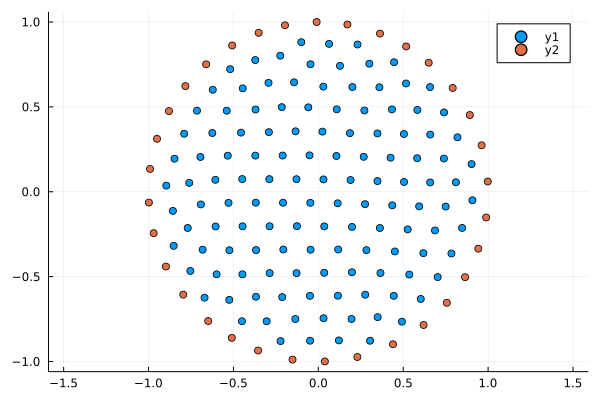

In [22]:
# plot the domain and boundary points 
Plots.scatter(Internal_points[1,:],Internal_points[2,:],aspect_ratio=:equal)
Plots.scatter!(Boundary_points[1,:],Boundary_points[2,:],aspect_ratio=:equal)

In [5]:


time = Observable(0.0)
xs = Internal_points[1,:]
ys = Internal_points[2,:]
us = @lift ux_true($time)
vs = @lift uy_true($time)
title = @lift string(round($time, digits=2))
strength2 = @lift (sqrt.(ux_true($time+0.01) .^ 2 .+ uy_true($time+0.01) .^ 2) )

fig = Figure(resolution = (800, 800))
Axis(fig[1, 1], backgroundcolor = "black",title = title)
arrows!(xs, ys, us, vs, arrowsize = 10, lengthscale = 0.2, arrowcolor = strength2, linecolor = strength2) #, 
framerate = 30
timestamps = range(0.0, 2π, step=1/framerate)
record(fig, "time_animation.gif", timestamps; framerate = framerate) do ti
    time[] = ti
end
print(strength2)

Observable{Vector{Float64}} with 2 listeners. Value:
[2.131612271551332, 1.9845086468049906, 2.235456171860433, 2.2393533875491776, 1.8241607602360026, 2.1461120820618325, 1.8431342671979647, 1.5517973818639668, 1.3939203599605947, 1.744155282230721, 1.7053456565509328, 1.2633850485891884, 1.7441552810749816, 1.263385048765288, 1.705345656077925, 1.2997486450124844, 2.106545670110082, 1.2997486461655585, 1.6949622496534196, 2.1164745052190543, 2.1065456695996625, 2.1164745070334092, 2.146112081647123, 1.3939203559241535, 1.5517973776585685, 2.2354561666656694, 2.1316122694068786, 1.9845086429867518, 1.8431342614642945, 2.239353385088663, 1.8241607561003628, 2.169457381061506, 2.248182471599359, 1.9617950129679909, 1.4917704802287022, 2.2445570576859697, 1.4242051479636335, 1.859411079749271, 1.8122927883755127, 2.1685876358643608, 1.8628533365197812, 0.2905094123307817, 0.23651514363510176, 0.4191815996990992, 0.69319839108562, 1.338004171471716, 1.1024734389369515, 1.0534879555699845,

In [23]:
# calculate matrices for the simulation 
param = 5
tensor_internal_internal =(point_difference_tensor(Internal_points,Internal_points))
tensor_internal_all = (point_difference_tensor(Internal_points,All_points))
tensor_all_all = (point_difference_tensor(All_points,All_points))
tensor_internal_boundary = (point_difference_tensor(Internal_points,Boundary_points))
tensor_boundary_boundary = (point_difference_tensor(Boundary_points,Boundary_points))


A_internal = apply_matrix(Φ, tensor_internal_internal, param)
A_div_internal = apply_matrix(Φ_div, tensor_internal_internal, param)
P = A_div_internal*inv(A_internal)

B =  apply_matrix(ΔΦ_normal, tensor_internal_all, param)
A = apply_matrix(Φ_normal, tensor_all_all, param)
L = B*inv(A)
Li = L[:,1:2*N_i]
Lb = L[:,2*N_i+1:end]

println("cond A_internal:", cond(A_internal))
#println("cond A_div_internal:", cond(mA_div_internal))
println("cond A:", cond(A))

println("cond P*Li:", cond(P*Li))
#println("cond L_i:", cond(mP*mL_i))
println("max eigenval Li: ",maximum(real.(eigvals(Li))))
println("max eigenval P*Li: ",maximum(real.(eigvals(P*Li))))







cond A_internal:13.52133582490456
cond A:240.03682497037747
cond P*Li:6.225136208105632e6
max eigenval Li: -5.8644190255494095
max eigenval P*Li: -8.274369717851295e-5


In [91]:
fdistance(p) = sqrt(sum(p .^ 2)) - 1
fedgelength(p) = 1#/(sqrt(sum(p .^ 2))+1)

function generate_points_circle(initdistance)
    boundingbox = [-1.1 -1.1; 1.1 1.1]
    x, y = distmesh2d(fdistance, fedgelength, boundingbox, initdistance)

    # generate points, reference solution, forcing vector, and boundary conditions 
    tx = unique(filter(e -> !isequal(e,NaN) ,x))
    ty = unique(filter(e -> !isequal(e,NaN) ,y))

    points = hcat(tx,ty)'

    Internal_points = []
    Boundary_points = []
    suma = 0
    for i in 1:length(tx)
        if abs(sum(points[:,i] .^2) - 1) < 1e-8
            #println(i)
            suma +=1
            append!(Boundary_points,[points[:,i]])
        else
            append!(Internal_points,[points[:,i]])
        end
        
    end

    Internal_points = hcat(Internal_points...)
    Boundary_points = hcat(Boundary_points...)

    return (Internal_points , Boundary_points)
end


function generate_matrices(Internal_points, Boundary_points,parameter)
    All_points = hcat(Internal_points,Boundary_points)
    N_i = size(Internal_points)[2]
    N_b = size(Boundary_points)[2]
    N = N_i + N_b
    u_true_internal = generate_vector_function(true_u₁,true_u₂,Internal_points)
    g = generate_vector_function(true_u₁,true_u₂,Boundary_points) # function values on the boundary 
    f = generate_vector_function(f₁,f₂,Internal_points) # forcing function on the domain 
    ∇p = generate_vector_function(true_∂₁p,true_∂₂p,Internal_points) # forcing function on the domain 
    ∂ₜg = generate_vector_function(true_∂ₜu₁,true_∂ₜu₂,Boundary_points)
    
    param = parameter
    tensor_internal_internal =(point_difference_tensor(Internal_points,Internal_points))
    tensor_internal_all = (point_difference_tensor(Internal_points,All_points))
    tensor_all_all = (point_difference_tensor(All_points,All_points))
    tensor_internal_boundary = (point_difference_tensor(Internal_points,Boundary_points))
    tensor_boundary_boundary = (point_difference_tensor(Boundary_points,Boundary_points))


    A_internal = apply_matrix(Φ, tensor_internal_internal, param)
    A_div_internal = apply_matrix(Φ_div, tensor_internal_internal, param)
    P = A_div_internal*inv(A_internal)

    B =  apply_matrix(ΔΦ_normal, tensor_internal_all, param)
    A = apply_matrix(Φ_normal, tensor_all_all, param)
    L = B*inv(A)
    Li = L[:,1:2*N_i]
    Lb = L[:,2*N_i+1:end]
    cond_A_internal = cond(A_internal)
    cond_A = cond(A)
    cond_P_Li = cond(P*Li)
    max_cond = maximum((cond_A_internal,cond_A,cond_P_Li))
    return u_true_internal,g,f,∇p,∂ₜg,P,Li,Lb,max_cond
end

function get_solution(u_true_internal,g,f,∇p,∂ₜg,P,Li,Lb,update_rule)
    u0 = u_true_internal(0)
    #println(length(u0))
    tspan = (0.0,2.0)
    prob1 = ODEProblem(update_rule,u0,tspan,[Li,Lb,P,f,g,∇p])
    sol = solve(prob1,ImplicitEuler())
    return sol
end
function update_rule1(du,u,p,t) # my version
    Li = p[1]
    Lb = p[2]
    P = p[3]
    f = p[4]
    g = p[5]
    ∇p = p[6]
    du .=  (Li * u .+ Lb * g(t) .+ f(t) .-∇p(t))
end

function update_rule2(du,u,p,t) # my version
    Li = p[1]
    Lb = p[2]
    P = p[3]
    f = p[4]
    g = p[5]
    ∇p = p[6]
    du .=  P*(Li * u .+ Lb * g(t) .+ f(t) .-∇p(t))
end

function error(initdistance,param,update_rule)
    Internal_points, Boundary_points = generate_points_circle(initdistance)
    u_true_internal,g,f,∇p,∂ₜg,P,Li,Lb,max_cond = generate_matrices(Internal_points, Boundary_points ,param)
    N_i = size(Internal_points)[2]
    N_b = size(Boundary_points)[2]
    N = N_i + N_b
    #display(Li)
    #display(Lb)
    #display(P)
    u0 = u_true_internal(0)
    #println(length(u0))
    #println(length(g(0)))
    tspan = (0.0,2.0)
    prob1 = ODEProblem(update_rule,u0,tspan,[Li,Lb,P,f,g,∇p])
    sol = solve(prob1,ImplicitEuler())
    e = maximum(abs.(vcat(u_true_internal.(0:0.01:2)...) - vcat(sol(0:0.01:2)...)))
    return e,N,max_cond
end

#points = generate_points(0.2)
#println(points)
#u_true_internal,g,f,∇p,∂ₜg,P,Li,Lb = generate_matrices(points...,5)
#display(Li)
#display(Lb)
#get_solution(u_true_internal,g,f,∇p,∂ₜg,P,Li,Lb,update_rule1)
error(0.3,6,update_rule2)

(1.1432698201714908, 41, 2.8130871658872776)

In [103]:
i_range = collect(0.3:-0.01:0.08)
N = length(i_range)
error_array = zeros(N)
N_array = zeros(N)
cond_number_array = zeros(N)
for (i,init_dist) in enumerate(i_range)
    error_array[i],N_array[i],cond_number_array[i] = error(init_dist,6,update_rule1)
    #error(i,5,update_rule1)
    #append!(error_array)
    #println(i,"   ",typeof(init_dist))
end

In [104]:

error_array2 = zeros(N)
cond_number_array2 = zeros(N)
for (i,init_dist) in enumerate(i_range)
    error_array2[i],N_array[i],cond_number_array2[i] = error(init_dist,6,update_rule2)
    print(i," ")
end

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 

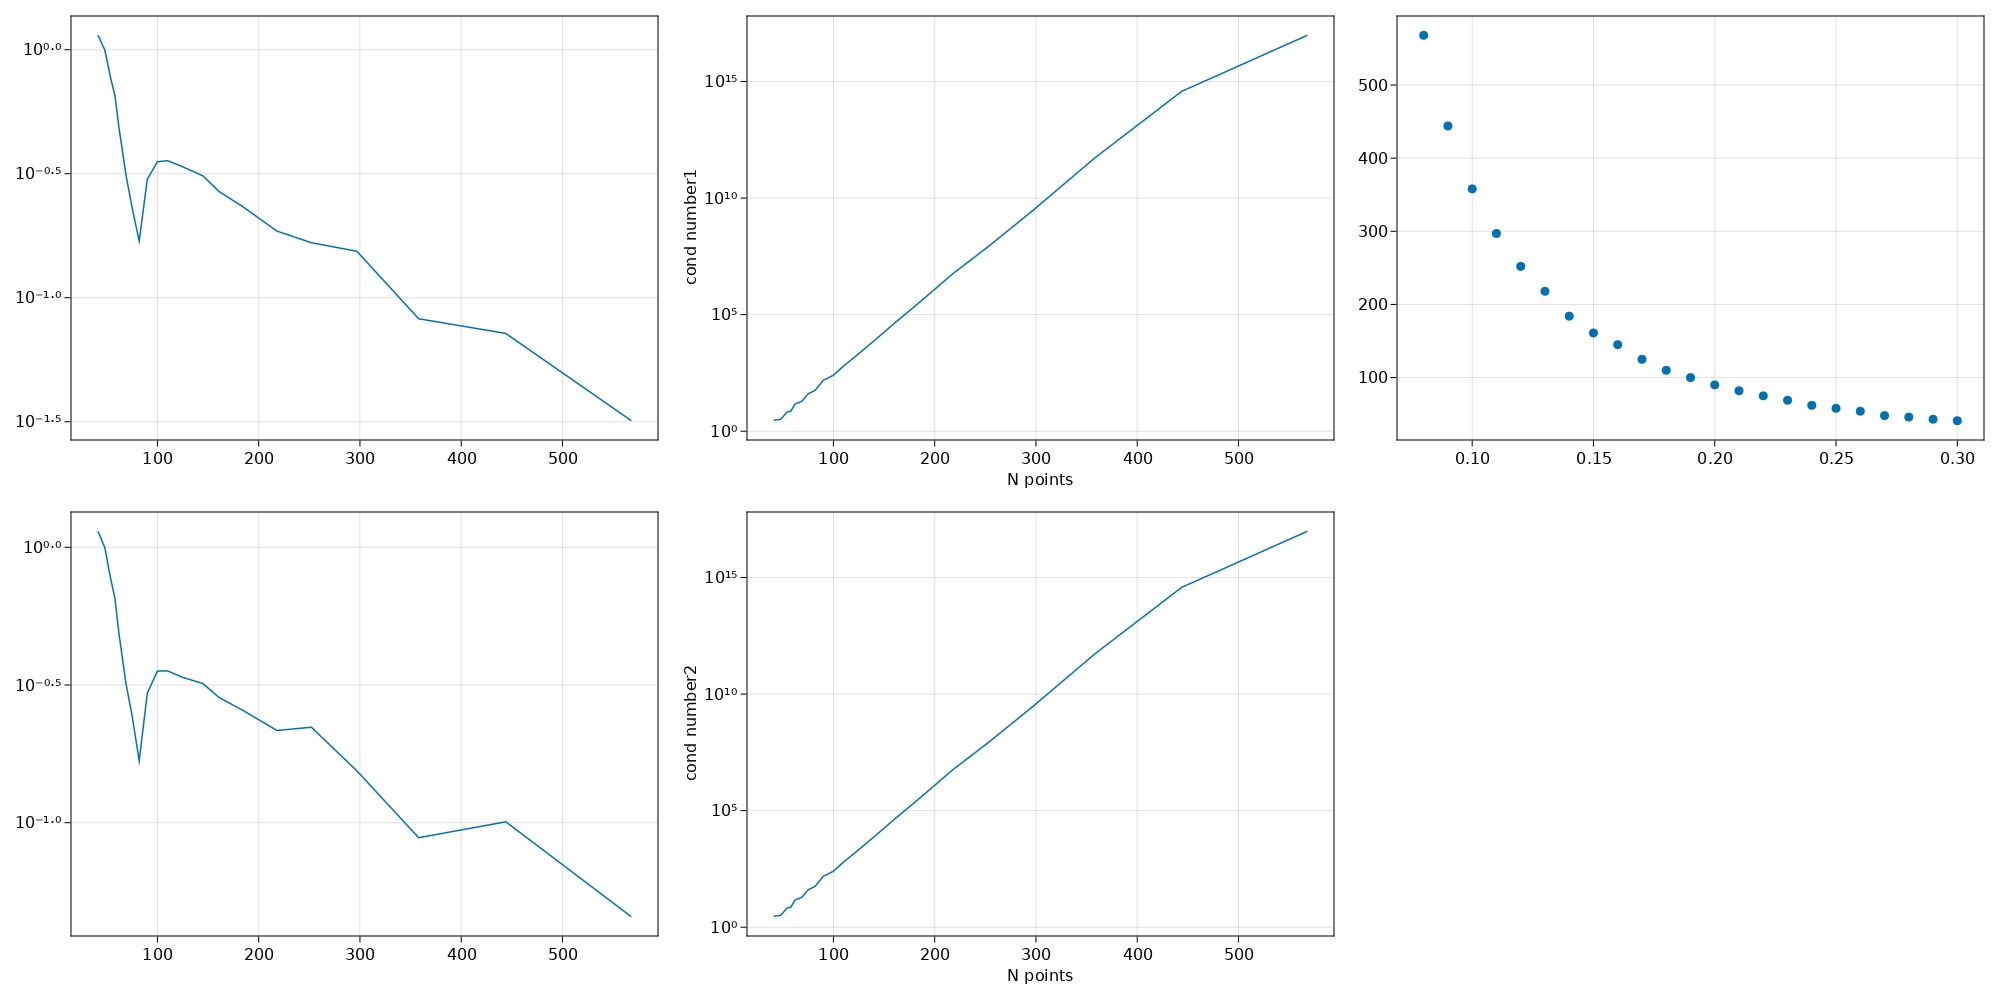

In [108]:
fig = Figure(resolution=(2000,1000))
subfig1 = fig[1, 1] = GridLayout()
subfig2 = fig[1, 2] = GridLayout()
subfig3 = fig[1, 3] = GridLayout()
subfig4 = fig[2, 1] = GridLayout()
subfig5 = fig[2, 2] = GridLayout()
ax1 = Axis(subfig1[1,1],yscale = log10)
ax2 = Axis(subfig2[1,1],ylabel="cond number1",xlabel = "N points",yscale = log10)
ax3 = Axis(subfig3[1,1])
ax4 = Axis(subfig4[1,1],yscale = log10)
ax5 = Axis(subfig5[1,1],ylabel="cond number2",xlabel = "N points",yscale = log10)
CairoMakie.lines!(ax1,N_array,error_array)
CairoMakie.lines!(ax2,N_array,cond_number_array)
CairoMakie.scatter!(ax3,i_range,N_array)

CairoMakie.lines!(ax4,N_array,error_array2)
CairoMakie.lines!(ax5,N_array,cond_number_array2)
fig

In [8]:
using DifferentialEquations
using Sundials
function f1!(du,u,p,t) # my version
    L_i = p[1]
    L_b = p[2]
    P = p[3]
    f = p[4]
    g = p[5]
    ∇p = p[6]
    du .=  (Li * u .+ Lb * g(t) .+ f(t) .-∇p(t))
    #return du
end


u0 = u_true_internal(0)
tspan = (0.0,2.0)
prob1 = ODEProblem(f1!,u0,tspan,[Li,Lb,P,f,g,∇p])
sol = solve(prob1,ImplicitEuler())
println("done")

done


In [9]:
println(maximum(abs.(sol(1.3) - u_true_internal(1.3))))
println(maximum(vcat(sol[:]...)))
println(maximum(vcat(u_true_internal.(0:0.1:2)...)))
maximum(abs.(vcat(u_true_internal.(0:0.01:2)...) - vcat(sol(0:0.01:2)...)))


0.029755356323085902
2.9250725768385935
2.9180087581827014


0.03804944545533617

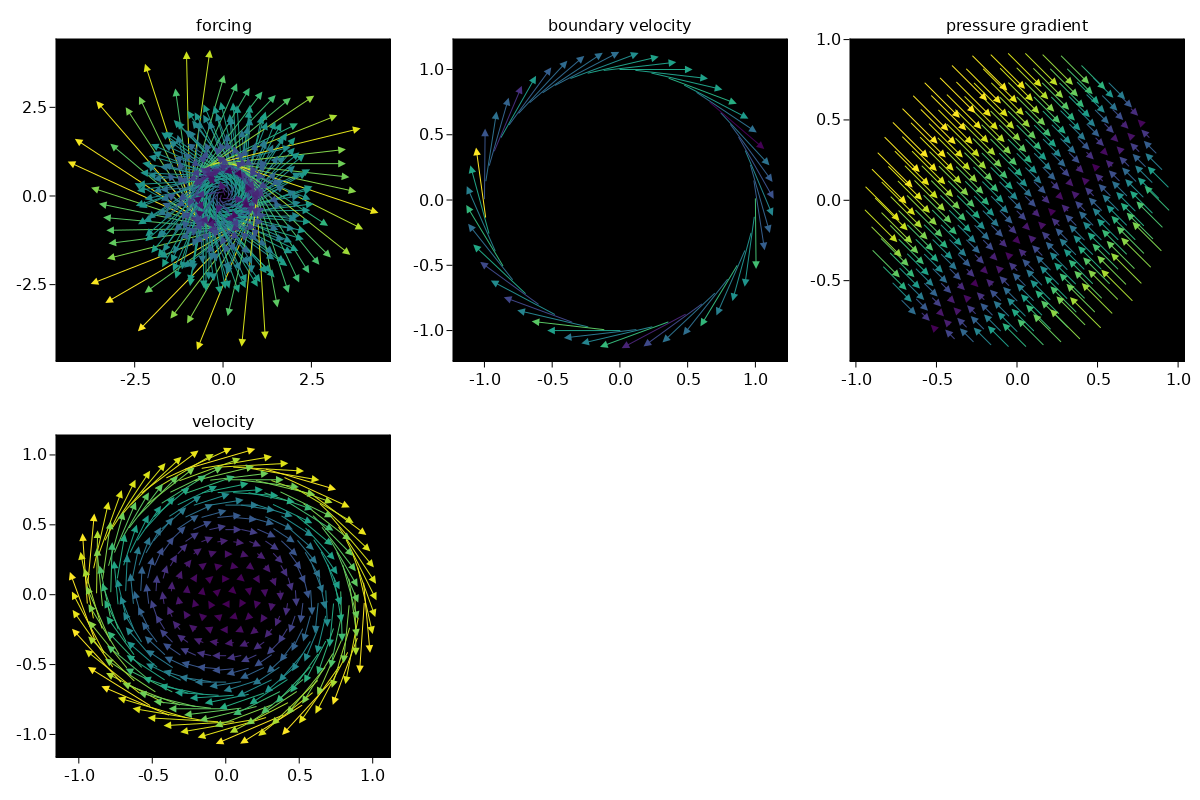

In [10]:

t_interest = 1.3
xsi = Internal_points[1,:]
ysi = Internal_points[2,:]

u = sol(t_interest)[1:2:2*N_i]
v = sol(t_interest)[2:2:2*N_i]

usi = f(t_interest)[1:2:2*N_i]
vsi = f(t_interest)[2:2:2*N_i]

up = ∇p(t_interest)[1:2:2*N_i]
vp = ∇p(t_interest)[2:2:2*N_i]

xsb = Boundary_points[1,:]
ysb = Boundary_points[2,:]
usb = g(t_interest)[1:2:2*N_b]
vsb = g(t_interest)[2:2:2*N_b]

strengthi = (sqrt.( usi.^ 2 .+  vsi.^ 2) )
strengthb = (sqrt.( usb.^ 2 .+  vsb.^ 2) )
strengthp = (sqrt.( (up.+0.0).^ 2 .+  (vp .+0.0).^ 2) )
strengthsol = (sqrt.( (u.+0.0).^ 2 .+  (v .+0.0).^ 2) )

fig = Figure(resolution = (3*400, 2*400))
subfig1 = fig[1, 1] = GridLayout()
subfig2 = fig[1, 2] = GridLayout()
subfig3 = fig[1, 3] = GridLayout()
subfig4 = fig[2, 1] = GridLayout()
ax1 = Axis(subfig1[1, 1], backgroundcolor = "black",title = "forcing")
ax2 = Axis(subfig2[1, 1], backgroundcolor = "black",title = "boundary velocity")
ax3 = Axis(subfig3[1, 1], backgroundcolor = "black",title = "pressure gradient")
ax4 = Axis(subfig4[1, 1], backgroundcolor = "black",title = "velocity")
arrows!(ax1,xsi, ysi, usi, vsi, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthi, linecolor = strengthi) #,
arrows!(ax2,xsb, ysb, usb, vsb, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthb, linecolor = strengthb) #,
arrows!(ax3,xsi, ysi, up, vp, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthp, linecolor = strengthp) #,
arrows!(ax4,xsi, ysi,u , v, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthsol, linecolor = strengthsol)
fig
#save("testingg.png",fig)

#println(up .^2 .+ vp .^2)

In [11]:
time = Observable(0.0)
xs = Internal_points[1,:]
ys = Internal_points[2,:]
us = @lift sol($time)[1:2:2*N_i]
vs = @lift sol($time)[2:2:2*N_i]
title = @lift string(round($time, digits=2))
strength2 = @lift sqrt.(sol($time+0.01)[1:2:2*N_i] .^ 2 .+ sol($time+0.01)[2:2:2*N_i] .^ 2) 

fig = Figure(resolution = (800, 800))
Axis(fig[1, 1], backgroundcolor = "black",title = title)
arrows!(xs, ys, us, vs, arrowsize = 10, lengthscale = 0.05, arrowcolor = strength2, linecolor = strength2) #, 
framerate = 30
timestamps = range(0.0, 2, step=1/framerate)
record(fig, "my_method.gif", timestamps; framerate = framerate) do ti
    time[] = ti
end


"my_method.gif"